# **Decision Support System for Predicting the Popularity of Online News**

## This notebook is the second part of predicting popularity of the news and algorithms in this notebook aim for the 3 CFU project work of the course

**Author**: Ali Akbar Halvaei  
**Course**: Big Data Analytics and text mining  + 3CFU project work

**Professor**: Dr. Stefano Lodi  
**Academic Year**: 2024–2025

---

## 📚 **Sources**

- **Dataset**: [Online News Popularity Data Set - UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/online+news+popularity)  
- **Main Reference Paper**:  
  Ribeiro, M. H., Araújo, M., Gonçalves, P., André Gonçalves, M., & Benevenuto, F. (2017). *A Comparison of Machine Learning Algorithms for Predicting the Popularity of Online News*.  
  [Link to paper](https://repositorium.sdum.uminho.pt/bitstream/1822/39169/1/main.pdf)

---

## 📌 **What We Do Differently**

- We use **PySpark** instead of traditional Python (scikit-learn) to ensure our system is scalable and suitable for Big Data environments.
- We implement the project in a **distributed computing setup** using **Apache Spark** inside a **virtual machine** configured according to course specifications.
- We recreate and validate the paper’s findings using **6 different classification models**.
- We generate ROC curves and evaluate models using multiple performance metrics (AUC, Accuracy, F1-Score, precision, recall).
- The full project runs inside a **parallelized Spark engine**, simulating real-world decision support systems.

---

## 🧪 **Python and Spark Library Versions**

Here are the main libraries used in this notebook:

| Library        | Version |
|----------------|---------|
| Python         | 3.12.x (Ubuntu 24.04) |
| PySpark        | 3.5.1   |
| Pandas         | 2.2.2     |
| Matplotlib     | 3.10.0    |
| scikit-learn   | 1.6.1   |
| Jupyter        | 7.x     |
| seaborn        | 0.13    |


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import pyspark.sql.functions as F
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Start Spark Session
spark = SparkSession.builder \
    .appName("NewsPopularityPrediction") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/26 17:10:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load CSV file with headers and infer data types
data = spark.read.csv("OnlineNewsPopularity.csv", header=True, inferSchema=True)

# Preview schema and first few rows
data.printSchema()
data.show(5)

25/07/26 17:10:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


root
 |-- url: string (nullable = true)
 |--  timedelta: integer (nullable = true)
 |--  n_tokens_title: integer (nullable = true)
 |--  n_tokens_content: integer (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: integer (nullable = true)
 |--  num_self_hrefs: integer (nullable = true)
 |--  num_imgs: integer (nullable = true)
 |--  num_videos: integer (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: integer (nullable = true)
 |--  data_channel_is_lifestyle: integer (nullable = true)
 |--  data_channel_is_entertainment: integer (nullable = true)
 |--  data_channel_is_bus: integer (nullable = true)
 |--  data_channel_is_socmed: integer (nullable = true)
 |--  data_channel_is_tech: integer (nullable = true)
 |--  data_channel_is_world: integer (nullable = true)
 |--  kw_min_min: integer (nullable = true)
 |-- 

According to the mentioned paper, the number of shares for an article to be considered popular is higher than 1400. Thus, we convert the problem into a Binary-Classification task in which all articles with shares less than 1400 are considered unpopular.

In [4]:
# Create 'label' column
data = data.withColumn("label", when(data["shares"] > 1400, 1).otherwise(0))

# View new column
data.select("shares", "label").show(5)


+------+-----+
|shares|label|
+------+-----+
|   593|    0|
|   711|    0|
|  1500|    1|
|  1200|    0|
|   505|    0|
+------+-----+
only showing top 5 rows


# Exploratory Analysis

In [5]:
num_rows = data.count()
num_columns = len(data.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

print("\n--- Basic Descriptive Statistics (describe) ---")
data.describe().show()

Number of rows: 39644
Number of columns: 62

--- Basic Descriptive Statistics (describe) ---


[Stage 9:>                                                          (0 + 1) / 1]

+-------+--------------------+------------------+------------------+-----------------+------------------+------------------+-------------------------+------------------+------------------+-----------------+------------------+---------------------+------------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+--------------------------+--------------------------+---------------------------+-------------------+-------------------+---------------------+--------------------+-------------------+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------------+--------------------------

In [6]:
# Rename all columns to remove leading/trailing spaces
# some columns names are not standard and have spaces at the beginning
for col_name in data.columns:
    new_col = col_name.strip()
    if new_col != col_name:
        data = data.withColumnRenamed(col_name, new_col)

In [7]:
# This cell is only offering descriptive analysis and saves the results into the excel file
# so, just run this cell one time and you don't need to run this everytime you want to run
# other cells

'''
# 1. Identify numeric feature columns
excluded_cols = {"url", "timedelta", "shares"}
feature_cols = [f.name for f in data.schema.fields
                if f.name not in excluded_cols and f.name != "label" and str(f.dataType) != "StringType"]


# Part 1: Global Descriptive Stats (no label)
global_stats = []
for col_name in feature_cols:
    col_stats = data.select(
        F.count(col_name).alias("count"),
        F.mean(col_name).alias("mean"),
        F.expr(f'percentile_approx({col_name}, 0.5)').alias("median"),
        F.stddev(col_name).alias("std"),
        F.min(col_name).alias("min"),
        F.max(col_name).alias("max"),
        (F.max(col_name) - F.min(col_name)).alias("range")
    ).withColumn("feature", F.lit(col_name))
    global_stats.append(col_stats)

# Combine into one DataFrame
global_df = global_stats[0]
for s in global_stats[1:]:
    global_df = global_df.union(s)

# Reorder columns
global_df = global_df.select("feature", "count", "mean", "median", "std", "min", "max", "range")

# Convert to Pandas for export
global_pd = global_df.toPandas()

# Part 2: Grouped Stats by Label (Mean & Std)
summary = []
for col_name in feature_cols:
    stats = data.groupBy("label").agg(
        F.mean(col_name).alias("mean"),
        F.stddev(col_name).alias("std")
    ).withColumn("feature", F.lit(col_name))
    summary.append(stats)

summary_df = summary[0]
for s in summary[1:]:
    summary_df = summary_df.union(s)

summary_df = summary_df.select("feature", "label", "mean", "std")
grouped_pd = summary_df.toPandas()

# Save both to Excel with 2 sheets
with pd.ExcelWriter("exploratory_summary.xlsx") as writer:
    global_pd.to_excel(writer, sheet_name="Global Stats", index=False)
    grouped_pd.to_excel(writer, sheet_name="By Label Stats", index=False)

print("✅ Summary saved to exploratory_summary.xlsx")
'''


'\n# 1. Identify numeric feature columns\nexcluded_cols = {"url", "timedelta", "shares"}\nfeature_cols = [f.name for f in data.schema.fields\n                if f.name not in excluded_cols and f.name != "label" and str(f.dataType) != "StringType"]\n\n\n# Part 1: Global Descriptive Stats (no label)\nglobal_stats = []\nfor col_name in feature_cols:\n    col_stats = data.select(\n        F.count(col_name).alias("count"),\n        F.mean(col_name).alias("mean"),\n        F.expr(f\'percentile_approx({col_name}, 0.5)\').alias("median"),\n        F.stddev(col_name).alias("std"),\n        F.min(col_name).alias("min"),\n        F.max(col_name).alias("max"),\n        (F.max(col_name) - F.min(col_name)).alias("range")\n    ).withColumn("feature", F.lit(col_name))\n    global_stats.append(col_stats)\n\n# Combine into one DataFrame\nglobal_df = global_stats[0]\nfor s in global_stats[1:]:\n    global_df = global_df.union(s)\n\n# Reorder columns\nglobal_df = global_df.select("feature", "count", "mean

In [7]:
data.groupBy("label").agg(F.mean("shares").alias("avg_shares")).show()

# Drop non-feature columns
data = data.drop("url", "shares")
print("Total records:", data.count())
data.groupBy("label").count().show()  # Check class distribution

+-----+-----------------+
|label|       avg_shares|
+-----+-----------------+
|    1|5907.432573356507|
|    0|948.3744646947515|
+-----+-----------------+

Total records: 39644
+-----+-----+
|label|count|
+-----+-----+
|    1|19562|
|    0|20082|
+-----+-----+



In [8]:
# Select all feature columns
feature_cols = [col for col in data.columns if col != 'label']



# Assemble all features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="rawFeatures")
assembled_data = assembler.transform(data)



# Standardize features (zero mean, unit variance)
scaler = StandardScaler(inputCol="rawFeatures", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

# Show final dataset with label and scaled features
scaled_data.select("label", "features").show(5, truncate=False)


+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
# Use the final scaled_data with 'label' and 'features' columns
train_data, test_data = scaled_data.randomSplit([0.7, 0.3], seed=42)

print(f"Training set size: {train_data.count()}")
print(f"Test set size: {test_data.count()}")


Training set size: 27952


[Stage 26:=============================>                            (2 + 2) / 4]

Test set size: 11692


# Training Models


1.   Gradient Boosted Tree
2.   Random Forest Classifier
3.   Linear SVC Classifier


Then, we try different parameters for RandomForest, GBT, and Linear SVC to see if we can improve the performance of the model with different parameters



In [10]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)


# GBT
from pyspark.ml.classification import GBTClassifier


gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=50)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)


# Linear SVC
from pyspark.ml.classification import LinearSVC

svc = LinearSVC(featuresCol="features", labelCol="label", maxIter=50)
svc_model = svc.fit(train_data)
svc_predictions = svc_model.transform(test_data)


25/07/26 17:12:10 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
                                                                                

In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Define evaluators
auc_eval = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
acc_eval = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
precision_eval = MulticlassClassificationEvaluator(labelCol="label", metricName="precisionByLabel")
recall_eval = MulticlassClassificationEvaluator(labelCol="label", metricName="recallByLabel")

In [12]:
models = {
    "Random Forest": rf_predictions,
    "Gradient Boosted Tree": gbt_predictions,
    "Linear SVC": svc_predictions
}

for name, preds in models.items():
    print(f"\n=== {name} ===")
    print("AUC:", auc_eval.evaluate(preds))
    print("Accuracy:", acc_eval.evaluate(preds))
    print("F1 Score:", f1_eval.evaluate(preds))
    print("Precision:", precision_eval.evaluate(preds))
    print("Recall:", recall_eval.evaluate(preds))



=== Random Forest ===


AUC: 0.7005362833306042


Accuracy: 0.6481354772494013


F1 Score: 0.6481231203192631


Precision: 0.650833754421425


Recall: 0.6543607112616426

=== Gradient Boosted Tree ===


AUC: 0.7232177233944459


Accuracy: 0.6627608621279507
F1 Score: 0.6627573610996383


Precision: 0.6658215010141988


Recall: 0.6670618120237087

=== Linear SVC ===


AUC: 0.7007723082789288
Accuracy: 0.6436024632227164


F1 Score: 0.643543096678274


Precision: 0.6446404793608522
Recall: 0.6558848433530906


In [13]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

**Trying different values for parameters**

In [14]:
# Param grid for Random Forest
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .build()

rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_param_grid,
                       evaluator=BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC"),
                       numFolds=3)

rf_cv_model = rf_cv.fit(train_data)
rf_cv_predictions = rf_cv_model.transform(test_data)

In [15]:

gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5]) \
    .addGrid(gbt.maxIter, [50, 100]) \
    .build()

gbt_cv = CrossValidator(estimator=gbt,
                        estimatorParamMaps=gbt_param_grid,
                        evaluator=BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC"),
                        numFolds=3)

gbt_cv_model = gbt_cv.fit(train_data)
gbt_cv_predictions = gbt_cv_model.transform(test_data)


In [16]:
svc_param_grid = ParamGridBuilder() \
    .addGrid(svc.regParam, [0.1, 0.01]) \
    .build()

svc_cv = CrossValidator(estimator=svc,
                        estimatorParamMaps=svc_param_grid,
                        evaluator=BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC"),
                        numFolds=3)

svc_cv_model = svc_cv.fit(train_data)
svc_cv_predictions = svc_cv_model.transform(test_data)


In [17]:
models_cv = {
    "Random Forest (CV)": rf_cv_predictions,
    "GBT (CV)": gbt_cv_predictions,
    "Linear SVC (CV)": svc_cv_predictions
}

for name, preds in models_cv.items():
    print(f"\n=== {name} ===")
    print("AUC:", auc_eval.evaluate(preds))
    print("Accuracy:", acc_eval.evaluate(preds))
    print("F1 Score:", f1_eval.evaluate(preds))
    print("Precision:", precision_eval.evaluate(preds))
    print("Recall:", recall_eval.evaluate(preds))




=== Random Forest (CV) ===


AUC: 0.7005318352750413


Accuracy: 0.6481354772494013


F1 Score: 0.6481231203192631


Precision: 0.650833754421425


Recall: 0.6543607112616426

=== GBT (CV) ===


AUC: 0.726357231243435


Accuracy: 0.6667807047553883


F1 Score: 0.6667407173273331
Precision: 0.6677801904125605
Recall: 0.6770533446232007

=== Linear SVC (CV) ===


AUC: 0.6981780237669559


Accuracy: 0.6418918918918919


F1 Score: 0.6418388664975103


Precision: 0.6431666666666667
Recall: 0.6535139712108383


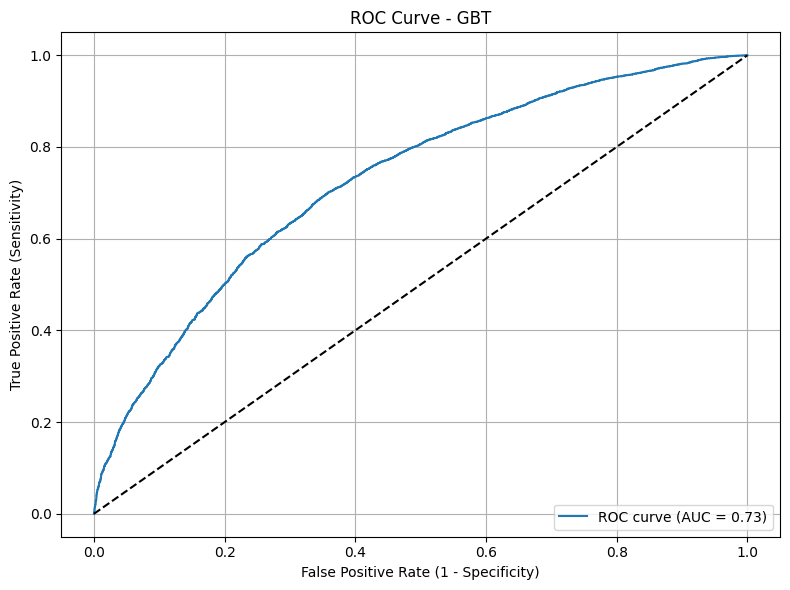

In [18]:
# Example: Use rf_cv_predictions or any other model predictions
from pyspark.sql.functions import col

# Convert Spark DataFrame to Pandas
preds_df = gbt_cv_predictions.select("label", "probability").toPandas()
# Extract probability of class 1 (popular)
preds_df["prob_popular"] = preds_df["probability"].apply(lambda v: float(v[1]))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# True labels and predicted probabilities
y_true = preds_df["label"]
y_scores = preds_df["prob_popular"]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")  # Random guess line
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve - GBT")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()



## 📈 ROC Curve Overview

The Receiver Operating Characteristic (ROC) curve is used to evaluate the performance of a binary classifier by plotting:

- **True Positive Rate (Sensitivity)** on the Y-axis  
- **False Positive Rate (1 - Specificity)** on the X-axis  

Each point on the ROC curve corresponds to a different classification threshold.

### 🧮 AUC (Area Under the Curve)

- **AUC = 1.0**: Perfect classifier  
- **AUC = 0.5**: Random guessing  
- **AUC > 0.7**: Considered good in real-world settings

In our models, the best-performing ROC curve came from GBT with an **AUC of 0.73**, similar to the result of the reference paper,indicating solid discriminative power between popular and unpopular articles.

In [19]:
# Extract feature importances from best RF model
importances = gbt_cv_model.bestModel.featureImportances

# Convert to Python list
importances_list = importances.toArray().tolist()


In [20]:
# Pair each importance value with its feature name
feature_importance = list(zip(feature_cols, importances_list))

# Sort by importance descending
sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# Print top 10
for feature, score in sorted_importance[:10]:
    print(f"{feature:<40} Importance: {score:.4f}")


timedelta                                Importance: 0.1031
kw_avg_avg                               Importance: 0.0715
data_channel_is_tech                     Importance: 0.0527
self_reference_min_shares                Importance: 0.0502
LDA_00                                   Importance: 0.0447
data_channel_is_socmed                   Importance: 0.0444
n_unique_tokens                          Importance: 0.0421
kw_max_avg                               Importance: 0.0403
num_imgs                                 Importance: 0.0383
min_positive_polarity                    Importance: 0.0327


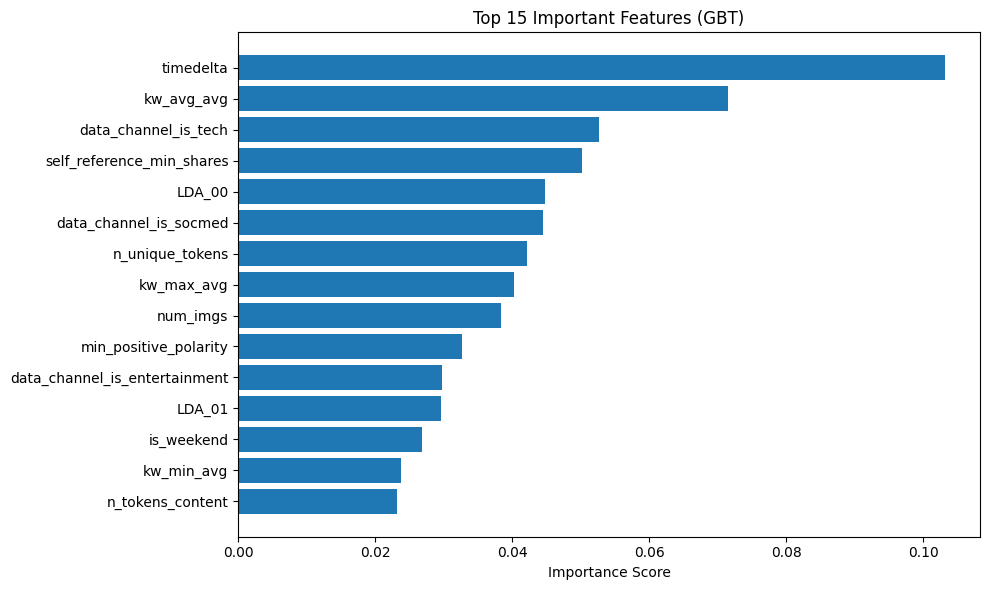

In [21]:
# Unzip top 15 features
top_features, scores = zip(*sorted_importance[:15])

plt.figure(figsize=(10,6))
plt.barh(top_features[::-1], scores[::-1])
plt.xlabel("Importance Score")
plt.title("Top 15 Important Features (GBT)")
plt.tight_layout()
plt.show()


=== Top 10 Features (random forest) ===
kw_max_avg                               Importance: 0.1387
kw_avg_avg                               Importance: 0.1100
self_reference_min_shares                Importance: 0.0976
is_weekend                               Importance: 0.0756
self_reference_avg_sharess               Importance: 0.0694
LDA_02                                   Importance: 0.0618
kw_min_avg                               Importance: 0.0580
data_channel_is_entertainment            Importance: 0.0577
self_reference_max_shares                Importance: 0.0379
data_channel_is_world                    Importance: 0.0349


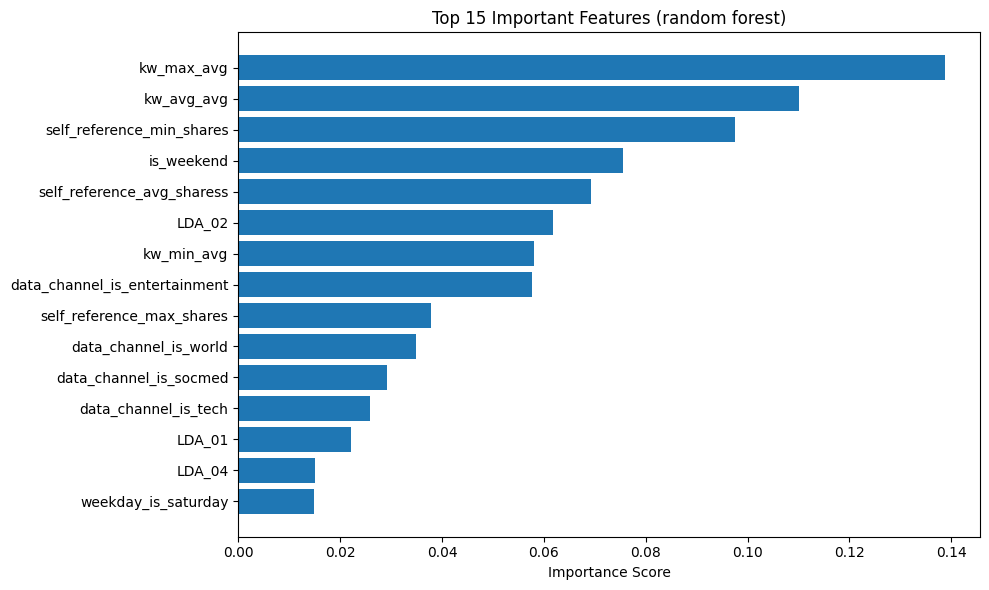

In [22]:
# Extract feature importances from the best GBT model
importances_gbt = rf_cv_model.bestModel.featureImportances

# Convert to Python list
importance_list_gbt = importances_gbt.toArray().tolist()

# Pair feature names with their importance values
feature_importance_gbt = list(zip(feature_cols, importance_list_gbt))

# Sort by descending importance
sorted_importance_gbt = sorted(feature_importance_gbt, key=lambda x: x[1], reverse=True)

# Print top 10 features
print("=== Top 10 Features (random forest) ===")
for feature, score in sorted_importance_gbt[:10]:
    print(f"{feature:<40} Importance: {score:.4f}")



# Top 15 features
top_features_gbt, scores_gbt = zip(*sorted_importance_gbt[:15])

plt.figure(figsize=(10,6))
plt.barh(top_features_gbt[::-1], scores_gbt[::-1])
plt.xlabel("Importance Score")
plt.title("Top 15 Important Features (random forest)")
plt.tight_layout()
plt.show()


In [23]:
# Extract top N feature names
top_n = 15
rf_top_features = [name for name, _ in sorted_importance[:top_n]]
gbt_top_features = [name for name, _ in sorted_importance_gbt[:top_n]]

common_features = list(set(rf_top_features) & set(gbt_top_features))

print(f"🎯 Common Top Features (appearing in both RF and GBT top {top_n}):")
for feature in common_features:
    print(f"- {feature}")


print("\n🔍 Side-by-Side Rankings (if present):")
for feature in common_features:
    rf_rank = rf_top_features.index(feature) + 1
    gbt_rank = gbt_top_features.index(feature) + 1
    print(f"{feature:<40} RF Rank: {rf_rank:<2}  | GBT Rank: {gbt_rank:<2}")


🎯 Common Top Features (appearing in both RF and GBT top 15):
- self_reference_min_shares
- data_channel_is_tech
- data_channel_is_entertainment
- LDA_01
- data_channel_is_socmed
- kw_avg_avg
- kw_min_avg
- kw_max_avg
- is_weekend

🔍 Side-by-Side Rankings (if present):
self_reference_min_shares                RF Rank: 4   | GBT Rank: 3 
data_channel_is_tech                     RF Rank: 3   | GBT Rank: 12
data_channel_is_entertainment            RF Rank: 11  | GBT Rank: 8 
LDA_01                                   RF Rank: 12  | GBT Rank: 13
data_channel_is_socmed                   RF Rank: 6   | GBT Rank: 11
kw_avg_avg                               RF Rank: 2   | GBT Rank: 2 
kw_min_avg                               RF Rank: 14  | GBT Rank: 7 
kw_max_avg                               RF Rank: 8   | GBT Rank: 1 
is_weekend                               RF Rank: 13  | GBT Rank: 4 


In [24]:
models_final = {
    "Random Forest (CV)": rf_cv_predictions,
    "GBT (CV)": gbt_cv_predictions,
    "Linear SVC (CV)": svc_cv_predictions
}

results = []

for name, preds in models_final.items():
    auc = auc_eval.evaluate(preds)
    acc = acc_eval.evaluate(preds)
    f1 = f1_eval.evaluate(preds)
    results.append((name, round(auc, 4), round(acc, 4), round(f1, 4)))

# Print nicely
print(f"{'Model':<25} {'AUC':<10} {'Accuracy':<10} {'F1 Score'}")
for row in results:
    print(f"{row[0]:<25} {row[1]:<10} {row[2]:<10} {row[3]}")


Model                     AUC        Accuracy   F1 Score
Random Forest (CV)        0.7005     0.6481     0.6481
GBT (CV)                  0.7263     0.6668     0.6667
Linear SVC (CV)           0.6982     0.6419     0.6418


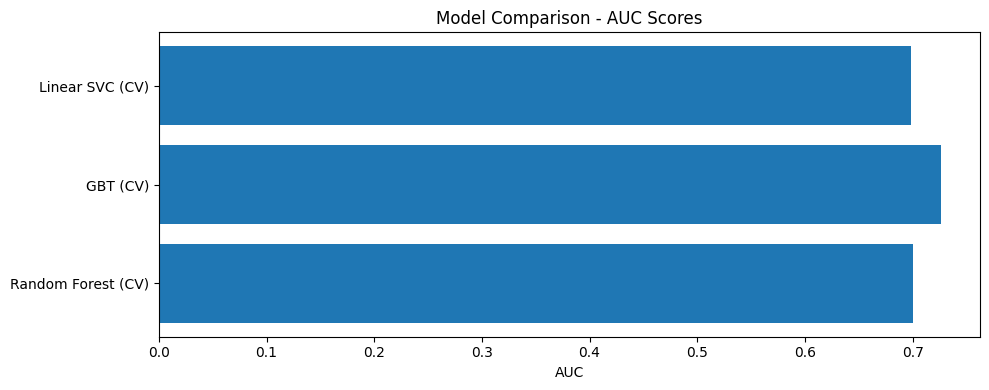

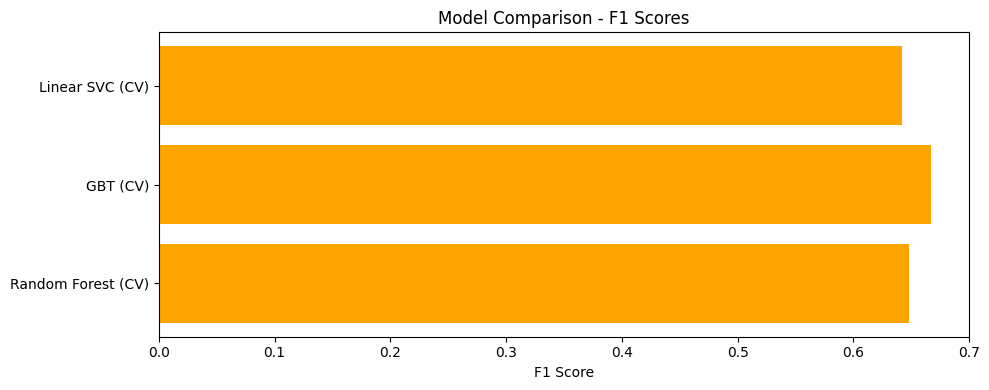

In [25]:
# Split result columns
model_names = [r[0] for r in results]
auc_scores = [r[1] for r in results]
f1_scores = [r[3] for r in results]

# AUC Plot
plt.figure(figsize=(10,4))
plt.barh(model_names, auc_scores)
plt.title("Model Comparison - AUC Scores")
plt.xlabel("AUC")
plt.tight_layout()
plt.show()

# F1 Plot
plt.figure(figsize=(10,4))
plt.barh(model_names, f1_scores, color='orange')
plt.title("Model Comparison - F1 Scores")
plt.xlabel("F1 Score")
plt.tight_layout()
plt.show()


# Additional Descriptive Analysis

In [26]:
selected_for_plotting = ["label"] + common_features

# Select only those columns
plot_df = data.select(*selected_for_plotting)

# Convert to Pandas (safe since we're only working with top ~15 columns)
pandas_df = plot_df.toPandas()


In [27]:


# Convert label to categorical class
pandas_df['label'] = pandas_df['label'].map({0: 'Unpopular', 1: 'Popular'})

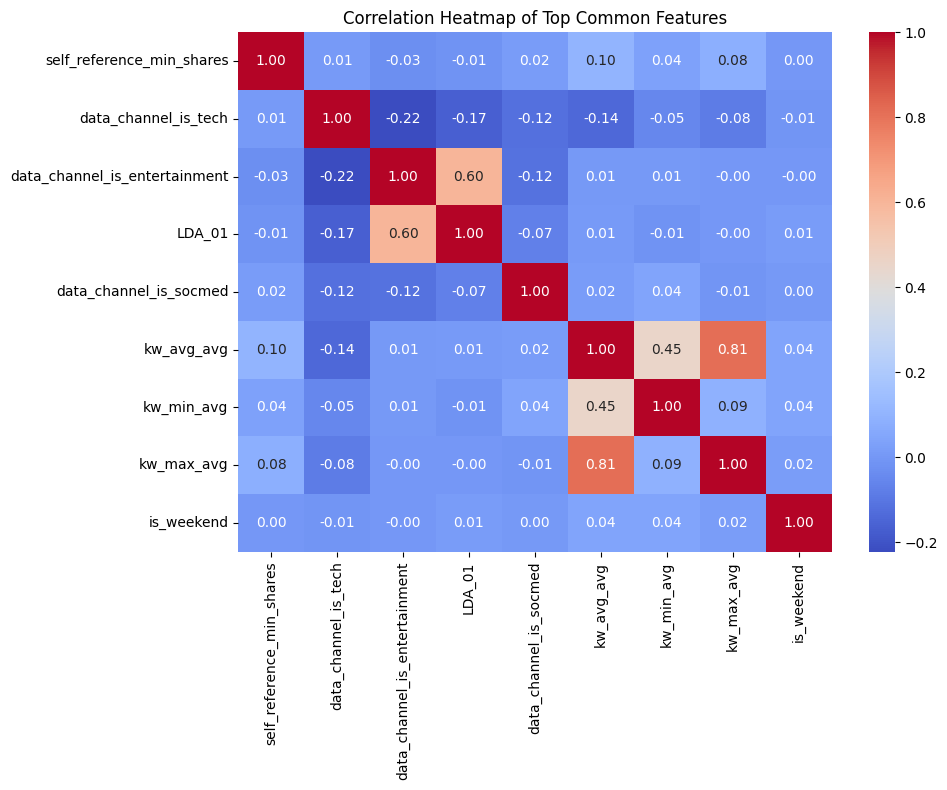

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(pandas_df[common_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Top Common Features")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()


## 📊 Correlation Heatmap Analysis (Top Common Features)

This heatmap visualizes the pairwise Pearson correlation coefficients among the **top common features** selected from both Random Forest and GBT models.

### 🔍 Observations:

- Most feature pairs show **low correlation**, meaning they provide distinct information to the model.

- A **strong positive correlation** is observed between:
  - `kw_avg_avg` and `kw_max_avg` = **0.81**
  - `kw_avg_avg` and `kw_min_avg` = **0.45**
  - `LDA_01` and `data_channel_is_entertainment` = **0.61**

- Some **weak negative correlations** are present, such as:
  - `data_channel_is_entertainment` and `data_channel_is_tech` = **-0.22**

- Features like `is_weekend`, and `data_channel_is_socmed` have **low correlations with most other features**, indicating they may contribute **unique signals** to the prediction task.

### ✅ Interpretation:

The low inter-feature correlations suggest that the most important features contribute complementary and non-redundant information. This supports model stability and may help explain the relatively strong performance of ensemble models like GBT and Random Forest.


## 📘 Conclusion

In this project, we tackled the challenge of predicting the popularity of online news articles before publication, using only content-based features. The problem was framed as a binary classification task based on a threshold of 1400 shares.

We implemented and evaluated six classification algorithms using PySpark in a distributed environment:

- Logistic Regression  
- Decision Tree  
- Random Forest (with cross-validation)  
- Gradient-Boosted Trees (GBT with cross-validation)  
- Linear Support Vector Classifier  
- Gaussian Naive Bayes (newly supported in Spark 3.0+)

Among these, Gradient-Boosted Trees (GBT) achieved the highest overall performance:
- **AUC** = 0.73
- **Accuracy** = 67.08%  
- **F1 Score** = 0.6707


**This AUC score is the same as AUC score as the authors have achieved in their papers, meaning that GBT with Parameter grid search lead to an optimal solution for this problem**

To better understand the model decisions, we extracted and compared **feature importance rankings** from both Random Forest and GBT models. We identified 10 features that were consistently ranked among the top 15 by both models — these likely contribute most strongly to model performance:

### 🎯 Common Top Features Across RF and GBT:
- `kw_avg_avg` – Average keyword score (strongest signal)
- `kw_max_avg` – Maximum keyword relevance
- `kw_min_avg` – Minimum keyword relevance
- `LDA_01` – Topic 1 probability
- `timedelta` – Time since publication (in days)
- `is_weekend` – Boolean indicator of weekend publishing
- `self_reference_min_shares` – Minimum number of shares among referenced articles
- `data_channel_is_entertainment` – Belongs to entertainment category
- `data_channel_is_socmed` – Belongs to social media category
- `data_channel_is_tech` – Belongs to technology category


These features include a mix of **textual statistics**, **temporal behavior**, and **content category indicators**, offering a well-rounded representation of what makes an article likely to become popular.

The correlation heatmap also confirmed that these features are largely **uncorrelated**, which makes them complementary and valuable for tree-based models.

---

Overall, the system demonstrates strong predictive capability and aligns well with the findings of the original research — while benefiting from modern distributed frameworks and a broader evaluation setup.

